In [1]:
from src.config import filepaths
from src.utils import construct_sparse_adj_mat, load_json
from src.similarity import rcmcs_similarity_matrix
import numpy as np
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd

rng = np.random.default_rng(seed=1234)

In [42]:
print(rdkit.__version__)

2023.09.5


In [2]:
smfp = filepaths['artifacts_sim_mats']

In [45]:
dataset = 'sprhea'
toc = 'v3_folded_pt_ns'

adj, idx_sample, idx_feature = construct_sparse_adj_mat(dataset, toc)
krs = load_json(filepaths['data_sprhea'] / f"{toc}.json")
rules = pd.read_csv(filepaths['data'] / "minimal1224_all_uniprot.tsv", sep='\t', )
rules.set_index('Name', inplace=True)

rxn_sim_metrics = [
    'bag_of_molecules_reactions',
    'rc_agg_r2_reactions',
    'rc_agg_r3_reactions',
    'rc_agg_r4_reactions',
    "rcmcs"
]

rxn_sim_mats = {name: np.load(smfp / f"{dataset}_{toc}_{name}.npy")
                for name in rxn_sim_metrics}

Constructing sprhea:v3_folded_pt_ns sparse adjacency matrix


In [32]:
filter_zero_rcmcs = False
n_points = 10000
n = rxn_sim_mats['rcmcs'].shape[0]
if filter_zero_rcmcs:
    idxs = np.vstack(np.nonzero(rxn_sim_mats['rcmcs'])).T
    idxs = idxs[idxs[:, 0] != idxs[:, 1]]
else:
    idxs = np.vstack(np.triu_indices(n, k=1)).T
sel = rng.choice(idxs.shape[0], size=n_points, replace=False)
idxs = idxs[sel]
i, j = idxs[:, 0], idxs[:, 1]

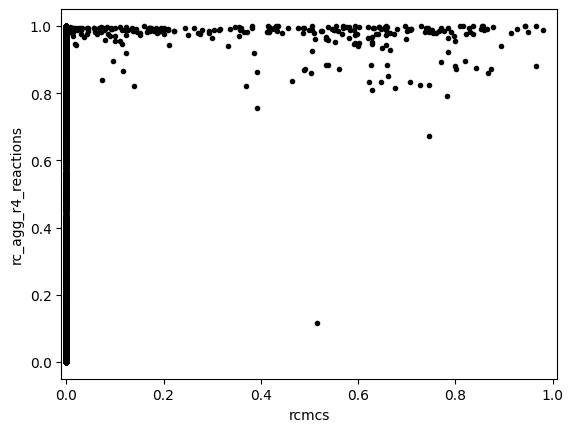

In [33]:
sim_mats = ['rcmcs', 'rc_agg_r4_reactions']
mean_sub_scl = False
data = []
for sm in sim_mats:
    data.append(rxn_sim_mats[sm][i, j])

x, y = data
if mean_sub_scl:
    x -= x.mean()
    x /= x.std()
    y -= y.mean()
    y /= y.std()
fig, ax = plt.subplots()
ax.plot(x, y, '.', color='black')
ax.set_xlabel(sim_mats[0])
ax.set_ylabel(sim_mats[1])
ax.set_xlim(-0.01, 1.01)
ax.set_xlim(-0.01, 1.01)
plt.show()

In [34]:
set(np.where(x > 0.9)[0]) & set(np.where(y < 0.1)[0])

set()

In [35]:
idx = 0


In [41]:

rid1 = idx_feature[i[idx]]
rid2 = idx_feature[j[idx]]
rxn1 = krs[idx_feature[i[idx]]]
rxn2 = krs[idx_feature[j[idx]]]
print(rid1, rid2, idx)
print(f"{sim_mats[0]} {x[idx]}", f"{sim_mats[1]} {y[idx]}")
reactions = {rid1: rxn1, rid2: rxn2}
idx2id = {0: rid1, 1: rid2}
idx +=1
rcmcs_similarity_matrix(
    rxns=reactions,
    rules=rules,
    matrix_idx_to_rxn_id=idx2id,
)

723 17662 5
rcmcs 0.0 rc_agg_r4_reactions 0.742508590221405
Preparing reaction pairs

Rxn # 0 : 723
Processing pairs



0it [00:00, ?it/s]


array([[1., 0.],
       [0., 1.]], dtype=float32)

In [15]:
idx = 38


2902 3073 38


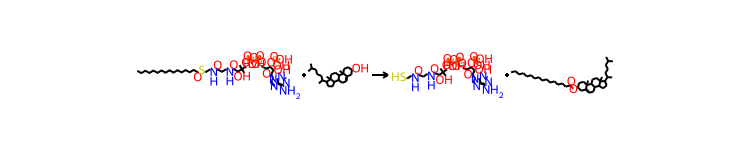

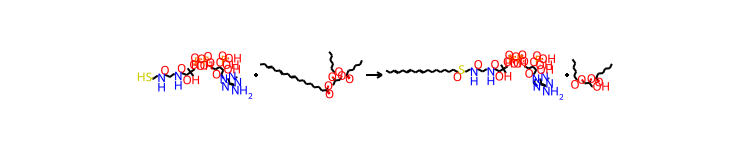

In [9]:

rid1 = idx_feature[i[idx]]
rid2 = idx_feature[j[idx]]
rxn1 = krs[idx_feature[i[idx]]]
rxn2 = krs[idx_feature[j[idx]]]
print(rid1, rid2, idx)
display(AllChem.ReactionFromSmarts(rxn1['smarts'], useSmiles=True))
display(AllChem.ReactionFromSmarts(rxn2['smarts'], useSmiles=True))
idx += 1

In [10]:
rxn1

{'smarts': 'CCCCCCCCCCCCCCCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O.CC(C)CCCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C>>CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS.CCCCCCCCCCCCCCCC(=O)OC1CCC2(C)C(=CCC3C2CCC2(C)C(C(C)CCCC(C)C)CCC32)C1',
 'min_rules': ['rule0022', 'rule0021'],
 'rcs': [[[15, 17], [18]], [[47], [15, 17]]],
 'enzymes': [{'uniprot_id': 'O77760',
   'sequence': 'MVGEEKMSLRNRLSKSRENPEEDEDQRKPAKESLEAPSNGRIDIKQLIAKKIKLTAEAEELKPFFMKEVGSHFDDFVTNLIEKSASLDNGGCALTTFSILEGEKNNHRAKDLRAPPEQGKIFIARRSLLDELLEVDHIRTIYHMFIALLILFILSTLVVDYIDEGRLVLEFSLLSYAFGKFPTVVWTWWIMFLSTFSVPYFLFQRWATGYSKSSHPLINSLFHGFLFMVFQIGILGFGPTYVVLAYTLPPASRFIIIFEQIRFVMKAHSFVRENVPRVLNSAKEKSSTVPIPTVNQYLYFLFAPTLIYRDSYPRNPTVRWGYVAMQFAQVFGCFFYVYYIFERLCAPLFRNIKQEPFSARVLVLCVFNSILPGVLILFLTFFAFLHCWLNAFAEMLRFGDRMFYKDWWNSTSYSNYYRTWNVVVHDWLYYYAYKDFLWFFSKRFKSAAMLAVFAVSAVVHEYALAVCLSFFYPVLFVLFMFFGMAFNFIVNDSRKKPIWNVMMWTSLFLGNGVLLCFYSQEWYARQHCPLKNP

In [11]:
rxn2

{'smarts': 'CC(C)(COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O)C(O)C(=O)NCCC(=O)NCCS.CCC=CCC=CCC=CCCCCCCCC(=O)OCC(COC(=O)CCCCC)OC(=O)CCCCC>>CCC=CCC=CCC=CCCCCCCCC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)(O)OP(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)(O)O.CCCCCC(=O)OCC(CO)OC(=O)CCCCC',
 'min_rules': ['rule0021', 'rule0022'],
 'rcs': [[[47], [17, 19]], [[17, 19], [11]]],
 'enzymes': [{'uniprot_id': 'Q9LW26',
   'sequence': 'MAVTVLPSVSGLSAVASSSNLRRLTSASNHRLTAIKSVTSTSSPPTPSSGVQRRRKNNDENRATVAKVVENPYSKVEAARPDLQKRLSDFLEEAREFVGDGGGPPRWFSPLECGAQATNSPLLLYLPGIDGTGLGLIRHHKKLGEIFDIWCLHIPVSDRTPVKDLVKLIEETVKSENFRLPNRPIYLVGESIGACLALDVAARNPNIDLSLILVNPATHVNNFMVQPLSGMLNVLPDGLPTLLEDIFDFGFKQGDPLTGMLDALSNEFSVQRMGGVGGGMLRDVLAVSANLPTLSRMFPKDTLLWKLEMLKYAIASVNSHIYSVRAETLILLSGRDHWLLKEEDIDRYSRTLPKCIVRKLDDNGQFPLLEDGVDLATIIKCTCFYRRGKSHDHITDYIMPTTFELKQQVDDHRLLMDGTSPVMLSTLEDGTVVRSLEGLPSEGPVLYVGYHMILGFELAPMVIQLMTERNIHLRGLAHPMLFKNLQDSLVDTKMFDKYKIMGGVPVSHFNIYKLLREKAHVLLYPGGVREALHRKGEEYKLFWPERSEFVRVASKFGAKIV